In [1]:
# importing liraries for data handling
import pymssql
import pandas as pd
import numpy as np

# importing libraries for data visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
from IPython.display import display
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.figure_factory as ff
import plotly.offline as py
import itertools
import plotly.graph_objs as go

In [3]:
# importing sklearn modules for preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2

# importing libraries for handling imbalance data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# importing libraries for data modelling
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
# importing modules for performance metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# importing misceallenous libraries
import pickle
import io
import os
import re
import sys
import warnings
warnings.filterwarnings("ignore")

In [5]:
cnxn = pymssql.connect(host='Auspwgsdfcst02.aus.amer.dell.com',database='Cadmus_KPI')
 
query = f'''
WITH 

----------------- OVERALL TABLE -----------------

OVERALL AS (

SELECT Employee_ID
,Preferred_Name
,Last_Hire_Date
,DATEDIFF(DAY, Last_Hire_Date, GETDATE()) AS [Tenure_Day]

,CASE WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 91 THEN 'a.0-3 Months'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 181 THEN 'b.3-6 Months'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 366 THEN 'c.6-12 Months'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 731 THEN 'd.1-2 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 1461 THEN 'e.2-4 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 2191 THEN 'f.4-6 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 2921 THEN 'g.6-8 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 3651 THEN 'h.8-10 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) >= 3651 THEN 'i.10+ Years'
	  ELSE 'Others' END AS Tenure_Group

,Employee_Type

,CASE WHEN Supp_Geo_2 = 'South_Asia' THEN 'SA'
	  WHEN Supp_Geo_2 = 'CH_HK_TW' THEN 'CCC'
	  WHEN Supp_Geo_2 = 'Australia_NZ' THEN 'ANZ'
	  WHEN Supp_Geo_2 = 'Japan_Korea' THEN 'JPN'
	  WHEN Supp_Geo_2 = 'India' THEN 'IND'
	  WHEN Supp_Geo_2 = 'Japan' THEN 'JPN'
	  WHEN Supp_Geo_2 = 'Korea' THEN 'KR'
	  ELSE 'Shared' END AS SubRegion

,Work_Region
,Work_Country
,[Location]

,Supervisor_Name
,Cost_Center_ID
,Cost_Center_Name
,CC
,COMB_QUEUE_NM
,[CCOQueueCode]
,[CCOQueueAbbr]
,LOB

,EPI_TITLE
,EPI_STATUS
,EPI_BUSINESS_UNIT
,EPI_Location
,EPI_TeamName

,MFR_Role
,Job_Title
,CASE WHEN Management_Level = 'Individual Contributor I10' THEN RIGHT(Management_Level,3)
	  WHEN Management_Level = 'Manager Level M10' THEN RIGHT(Management_Level,3)
	  ELSE RIGHT(Management_Level,2) END AS Job_Grade

,CASE WHEN MFR_Category IS NULL THEN 'Missing EPI'
	  WHEN MFR_Category = 'Frontline' AND L1_NonL1 = 'Non-L1' THEN MFR_Profile + '-Non L1'
	  WHEN MFR_Category = 'Frontline' THEN MFR_Profile + '-' + L1_NonL1
	  WHEN MFR_Category = 'Frontline Support' THEN MFR_Profile + '-' + SUBSTRING(R_NR_FLS, 0, CHARINDEX('-', R_NR_FLS, 0))					
	  WHEN MFR_Category = 'Non-Frontline' THEN 'NFL'
	  WHEN MFR_Category = 'UNKNOWN' THEN 'Missing EPI'
	  ELSE MFR_Category END AS [Function]

,RIGHT([F_Year],4) + '-' + LEFT([F_Year],2) AS Fiscal_Year
,RIGHT([F_Year],4) + '-' + LEFT([F_Quarter],2) AS Fiscal_Quarter
,RIGHT([F_Year],4) + '-' + [F_Month] AS Fiscal_Month
,[Fiscal_Week]

,CASE WHEN L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' THEN 1
	  WHEN NOT L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' AND L5_Mgr IN ('Brighton, Keith', 'Yap, Diane') THEN 1
	  ELSE 0 END AS [Paid_Managed_By]

,CASE WHEN L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' THEN 'Yes' ELSE 'No' END AS [PB_by_KM]

from
(SELECT Begin_date_Week
,Employee_ID
,Preferred_Name
,Last_Hire_Date
,Employee_Status
,Employee_Type
,Worker_Type
,Worker_Sub_Type
,Work_Phone
,Management_Level
,Per_Org
,Job_Family_Group
,Job_Family
,Contingent_Worker_Supplier
,FTE
,Exempt_Status
,Email_Address
,Jack_ID
,Manager_Indicator
,Frontline_Indicator
,Work_Region
,Work_Country
,Work_State
,Work_City
,[Location]
,Cost_Location
,Supervisor_Id
,Supervisor_Name
,Cost_Center_ID
,Cost_Center_Name
,CC
,L2_Mgr
,L3_Mgr
,L4_Mgr
,L5_Mgr
,L6_Mgr
,L7_Mgr
,L8_Mgr
,L9_Mgr
,EPI_TITLE
,EPI_VENDOR
,EPI_SEGMENT
,EPI_STATUS
,EWFMDeptCode
,EWFMTeamCode
,KanaUserID
,EPI_BUSINESS_UNIT
,EPI_SUB_SUPPORT
,EPI_SUBQUEUE
,Phone_Queue
,Capacity_Function
,MFR_Role
,MFR_Profile
,MFR_Category
,L1_NonL1
,R_NR_FLS
,MFR_Ratio_view
,MFR_Section_view
,case when Begin_date_Week >= '2019-08-31' and COMB_QUEUE_NM is null then ccoqueuecode
else COMB_QUEUE_NM end as COMB_QUEUE_NM
,LOB
,Product
,included_in_MFR
,EPI_STAT
,Region
,Facilities_Site
,CAPACITY_Site
,Factbook_Site
,L4_CC_MGR
,L5_CC_MGR
,L6_CC_MGR
,[CCOwner_Badge]
,[CCOwner]
,CC_REGION
,Supp_Geo_2
,Supp_Geo_3
,Supp_Geo_4
,Channel_3
,Function_2
,Function_3
,Business
,Offering
,CC_Type
,Layer
,Directs
,SPLIT
,Job_Title
      ,[CCOQueueCode]
      ,[CCOQueueAbbr]
,case when MFR_Role in ('SMAC Agent','Phone Agent','Federal TAM','E-Mail Agent','Delivery Engineer (DE)','Chat Agent','Case Director') then 'L1'						
when MFR_Role in ('Senior Engineer (SE)','Principal Engineer (PE)','Optimize Engineer','Master Engineer (ME)','L3 Engineer','Field Consultant','Escalations Agent','Centralized Tech Expert') then 'L2+'						
when MFR_Role in ('Manager') then 'Mgr'
when MFR_Role in ('Quality Lead (L2)') then 'QL(L2)'
when MFR_Role in ('Trainer','System Analyst','Partner Site Leads','M&A Analyst','Lab','Knowledge Management','Director','Auditors','Area Manager') then 'Support_FL'						
when MFR_Role in ('Tag Team') then 'Tag_Team'
when MFR_Role in ('Program Manager TAM','Data Analyst TAM') then 'TAM'
when MFR_Role in ('Technical Team Lead (TTL)','Technical Lead') then 'Technical_Lead'
when MFR_Role in ('UNKNOWN') or MFR_Role is null then 'UNKNOWN'
else MFR_Role end as 'INTERNAL_VIEW'

,case when MFR_Role in ('Tag Team','SMAC Agent','Phone Agent','Federal TAM','E-Mail Agent','Delivery Engineer (DE)','Chat Agent','Case Director') then 'DB_L1_Customer_Facing'						
when MFR_Role in ('Senior Engineer (SE)','Principal Engineer (PE)','Optimize Engineer','Master Engineer (ME)','L3 Engineer','Field Consultant','Escalations Agent','Centralized Tech Expert') then 'L2+_Customer_Facing'						
when MFR_Role in ('Trainer','Technical Team Lead (TTL)','Technical Lead','System Analyst','Quality Lead (L2)','Partner Site Leads','Manager','M&A Analyst','Lab','Knowledge Management','Director','Auditors','Area Manager') then 'Support_Frontline'						
when MFR_Role in ('Program Manager TAM','Data Analyst TAM') then 'TAM_Service'
when MFR_Role in ('UNKNOWN') or MFR_Role is null then 'UNKNOWN' else MFR_Role end as 'VIEW_Ratio'
,locationname EPI_Location
,EPI_TeamName , EPI_SupervisorName
FROM Headcount.[dbo].[HC_Final]

) H

inner join
(
SELECT [Begin_Date_Week]
      ,[End_Date_Week]
      ,[Fiscal_Week]
      ,[F_Month]
      ,[F_Quarter]
      ,[F_Year]
  FROM Cadmus_kpi.[dbo].[Calendar]
  group by [Begin_Date_Week]
      ,[End_Date_Week]
      ,[Fiscal_Week]
      ,[F_Month]
      ,[F_Quarter]
      ,[F_Year] ) C

on C.Begin_Date_Week = H.Begin_date_Week
WHERE Employee_Status <> 'Leave_of_Absence' AND Worker_Type = 'Employee' AND COMB_QUEUE_NM IS NOT NULL AND
(CASE WHEN L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' THEN 1
	  WHEN NOT L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' AND L5_Mgr IN ('Brighton, Keith', 'Yap, Diane') THEN 1
	  ELSE 0 END) = 1 AND

(CASE WHEN L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' THEN 'Yes' ELSE 'No' END = 'Yes')


),


----------------- MAX_WEEK TABLE -----------------

MAX_WEEK AS (

SELECT Employee_ID
,Preferred_Name
,Last_Hire_Date
,DATEDIFF(DAY, Last_Hire_Date, GETDATE()) AS [Tenure_Day]

,CASE WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 91 THEN 'a.0-3 Months'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 181 THEN 'b.3-6 Months'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 366 THEN 'c.6-12 Months'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 731 THEN 'd.1-2 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 1461 THEN 'e.2-4 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 2191 THEN 'f.4-6 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 2921 THEN 'g.6-8 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) < 3651 THEN 'h.8-10 Years'
	  WHEN DATEDIFF(DAY, Last_Hire_Date, GETDATE()) >= 3651 THEN 'i.10+ Years'
	  ELSE 'Others' END AS Tenure_Group

,Employee_Type

,CASE WHEN Supp_Geo_2 = 'South_Asia' THEN 'SA'
	  WHEN Supp_Geo_2 = 'CH_HK_TW' THEN 'CCC'
	  WHEN Supp_Geo_2 = 'Australia_NZ' THEN 'ANZ'
	  WHEN Supp_Geo_2 = 'Japan_Korea' THEN 'JPN'
	  WHEN Supp_Geo_2 = 'India' THEN 'IND'
	  WHEN Supp_Geo_2 = 'Japan' THEN 'JPN'
	  WHEN Supp_Geo_2 = 'Korea' THEN 'KR'
	  ELSE 'Shared' END AS SubRegion

,Work_Region
,Work_Country
,Work_State
,Work_City
,[Location]

,Supervisor_Name
,Cost_Center_ID
,Cost_Center_Name
,CC
,COMB_QUEUE_NM
,[CCOQueueCode]
,[CCOQueueAbbr]
,LOB

,EPI_TITLE
,EPI_STATUS
,EPI_BUSINESS_UNIT
,EPI_Location
,EPI_TeamName

,MFR_Role
,Job_Title
,CASE WHEN Management_Level = 'Individual Contributor I10' THEN RIGHT(Management_Level,3)
	  WHEN Management_Level = 'Manager Level M10' THEN RIGHT(Management_Level,3)
	  ELSE RIGHT(Management_Level,2) END AS Job_Grade

,CASE WHEN MFR_Category IS NULL THEN 'Missing EPI'
	  WHEN MFR_Category = 'Frontline' AND L1_NonL1 = 'Non-L1' THEN MFR_Profile + '-Non L1'
	  WHEN MFR_Category = 'Frontline' THEN MFR_Profile + '-' + L1_NonL1
	  WHEN MFR_Category = 'Frontline Support' THEN MFR_Profile + '-' + SUBSTRING(R_NR_FLS, 0, CHARINDEX('-', R_NR_FLS, 0))
	  WHEN MFR_Category = 'Non-Frontline' THEN 'NFL'
	  WHEN MFR_Category = 'UNKNOWN' THEN 'Missing EPI'
	  ELSE MFR_Category END AS [Function]

,RIGHT([F_Year],4) + '-' + LEFT([F_Year],2) AS Fiscal_Year
,RIGHT([F_Year],4) + '-' + LEFT([F_Quarter],2) AS Fiscal_Quarter
,RIGHT([F_Year],4) + '-' + [F_Month] AS Fiscal_Month
,[Fiscal_Week]

,CASE WHEN L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' THEN 1
	  WHEN NOT L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' AND L5_Mgr IN ('Brighton, Keith', 'Yap, Diane') THEN 1
	  ELSE 0 END AS [Paid_Managed_By]

,CASE WHEN L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' THEN 'Yes' ELSE 'No' END AS [PB_by_KM]

from
(SELECT Begin_date_Week
,Employee_ID
,Preferred_Name
,Last_Hire_Date
,Employee_Status
,Employee_Type
,Worker_Type
,Worker_Sub_Type
,Work_Phone
,Management_Level
,Per_Org
,Job_Family_Group
,Job_Family
,Contingent_Worker_Supplier
,FTE
,Exempt_Status
,Email_Address
,Jack_ID
,Manager_Indicator
,Frontline_Indicator
,Work_Region
,Work_Country
,Work_State
,Work_City
,[Location]
,Cost_Location
,Supervisor_Id
,Supervisor_Name
,Cost_Center_ID
,Cost_Center_Name
,CC
,L2_Mgr
,L3_Mgr
,L4_Mgr
,L5_Mgr
,L6_Mgr
,L7_Mgr
,L8_Mgr
,L9_Mgr
,EPI_TITLE
,EPI_VENDOR
,EPI_SEGMENT
,EPI_STATUS
,EWFMDeptCode
,EWFMTeamCode
,KanaUserID
,EPI_BUSINESS_UNIT
,EPI_SUB_SUPPORT
,EPI_SUBQUEUE
,Phone_Queue
,Capacity_Function
,MFR_Role
,MFR_Profile
,MFR_Category
,L1_NonL1
,R_NR_FLS
,MFR_Ratio_view
,MFR_Section_view
,case when Begin_date_Week >= '2019-08-31' and COMB_QUEUE_NM is null then ccoqueuecode
else COMB_QUEUE_NM end as COMB_QUEUE_NM
,LOB
,Product
,included_in_MFR
,EPI_STAT
,Region
,Facilities_Site
,CAPACITY_Site
,Factbook_Site
,L4_CC_MGR
,L5_CC_MGR
,L6_CC_MGR
,[CCOwner_Badge]
,[CCOwner]
,CC_REGION
,Supp_Geo_2
,Supp_Geo_3
,Supp_Geo_4
,Channel_3
,Function_2
,Function_3
,Business
,Offering
,CC_Type
,Layer
,Directs
,SPLIT
,Job_Title
      ,[CCOQueueCode]
      ,[CCOQueueAbbr]
,case when MFR_Role in ('SMAC Agent','Phone Agent','Federal TAM','E-Mail Agent','Delivery Engineer (DE)','Chat Agent','Case Director') then 'L1'						
when MFR_Role in ('Senior Engineer (SE)','Principal Engineer (PE)','Optimize Engineer','Master Engineer (ME)','L3 Engineer','Field Consultant','Escalations Agent','Centralized Tech Expert') then 'L2+'						
when MFR_Role in ('Manager') then 'Mgr'
when MFR_Role in ('Quality Lead (L2)') then 'QL(L2)'
when MFR_Role in ('Trainer','System Analyst','Partner Site Leads','M&A Analyst','Lab','Knowledge Management','Director','Auditors','Area Manager') then 'Support_FL'						
when MFR_Role in ('Tag Team') then 'Tag_Team'
when MFR_Role in ('Program Manager TAM','Data Analyst TAM') then 'TAM'
when MFR_Role in ('Technical Team Lead (TTL)','Technical Lead') then 'Technical_Lead'
when MFR_Role in ('UNKNOWN') or MFR_Role is null then 'UNKNOWN'
else MFR_Role end as 'INTERNAL_VIEW'

,case when MFR_Role in ('Tag Team','SMAC Agent','Phone Agent','Federal TAM','E-Mail Agent','Delivery Engineer (DE)','Chat Agent','Case Director') then 'DB_L1_Customer_Facing'						
when MFR_Role in ('Senior Engineer (SE)','Principal Engineer (PE)','Optimize Engineer','Master Engineer (ME)','L3 Engineer','Field Consultant','Escalations Agent','Centralized Tech Expert') then 'L2+_Customer_Facing'						
when MFR_Role in ('Trainer','Technical Team Lead (TTL)','Technical Lead','System Analyst','Quality Lead (L2)','Partner Site Leads','Manager','M&A Analyst','Lab','Knowledge Management','Director','Auditors','Area Manager') then 'Support_Frontline'						
when MFR_Role in ('Program Manager TAM','Data Analyst TAM') then 'TAM_Service'
when MFR_Role in ('UNKNOWN') or MFR_Role is null then 'UNKNOWN' else MFR_Role end as 'VIEW_Ratio'
,locationname EPI_Location
,EPI_TeamName , EPI_SupervisorName
FROM Headcount.[dbo].[HC_Final]

) H

inner join
(
SELECT [Begin_Date_Week]
      ,[End_Date_Week]
      ,[Fiscal_Week]
      ,[F_Month]
      ,[F_Quarter]
      ,[F_Year]
  FROM Cadmus_kpi.[dbo].[Calendar]
  group by [Begin_Date_Week]
      ,[End_Date_Week]
      ,[Fiscal_Week]
      ,[F_Month]
      ,[F_Quarter]
      ,[F_Year] ) C

on C.Begin_Date_Week = H.Begin_date_Week
WHERE Employee_Status <> 'Leave_of_Absence' AND Worker_Type = 'Employee' AND
(CASE WHEN L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' THEN 1
	  WHEN NOT L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' AND L5_Mgr IN ('Brighton, Keith', 'Yap, Diane') THEN 1
	  ELSE 0 END) = 1 AND

(CASE WHEN L5_CC_MGR = 'GS_DTS_TS_ISG_APJ' THEN 'Yes' ELSE 'No' END = 'Yes') AND

	 Fiscal_Week = (
					SELECT MAX([Fiscal_Week])
					from	
						(SELECT Begin_date_Week
						,Employee_Status
						,Worker_Type
						FROM Headcount.[dbo].[HC_Final]
						) H

					inner join

					(SELECT [Begin_Date_Week]
						  ,[End_Date_Week]
						  ,[Fiscal_Week]
						  ,[F_Month]
						  ,[F_Quarter]
						  ,[F_Year]
					  FROM Cadmus_kpi.[dbo].[Calendar]
					  group by [Begin_Date_Week]
						  ,[End_Date_Week]
						  ,[Fiscal_Week]
						  ,[F_Month]
						  ,[F_Quarter]
						  ,[F_Year] 
					) C

					on C.Begin_Date_Week = H.Begin_date_Week

					WHERE Employee_Status <> 'Leave_of_Absence' AND Worker_Type = 'Employee'	
					)

)



----------------- SELECT TABLE -----------------

SELECT OVERALL.*,
CASE WHEN MAX_WEEK.Employee_ID IS NULL THEN 1 ELSE 0 END AS [Leave/ Stay]

FROM OVERALL
LEFT JOIN MAX_WEEK
ON OVERALL.Employee_ID = MAX_WEEK.Employee_ID

WHERE OVERALL.[Fiscal_Week]>=(SELECT TOP 1 Fiscal_Week FROM OVERALL) AND OVERALL.[Fiscal_Quarter]>='2022-Q1' AND 
	  OVERALL.EPI_BUSINESS_UNIT = 'Infrastructure Solutions Group'	AND OVERALL.COMB_QUEUE_NM IS NOT NULL AND
      OVERALL.COMB_QUEUE_NM <> 'APJ Support Resolution Team'
ORDER BY OVERALL.Fiscal_Week DESC
 '''
  
agg_data = pd.read_sql(query, cnxn)

In [6]:
print("Shape of dataframe is: {}".format(agg_data.shape))

Shape of dataframe is: (80083, 34)


In [7]:
agg_data.head()

,Employee_ID,Preferred_Name,Last_Hire_Date,Tenure_Day,Tenure_Group,Employee_Type,SubRegion,Work_Region,Work_Country,Location,...,Job_Title,Job_Grade,Function,Fiscal_Year,Fiscal_Quarter,Fiscal_Month,Fiscal_Week,Paid_Managed_By,PB_by_KM,Leave/ Stay
0,1245100.0,"M, Chaithra",2020-01-13,821,e.2-4 Years,Regular,IND,Asia-Pacific/Japan,India,"Bangalore, India",...,Technical Support Engineer 2,I6,FL-L1,2023-FY,2023-Q1,2023-April,202310,1,Yes,0
1,1294965.0,"Zhou, Hathaway",2021-06-15,302,c.6-12 Months,Fixed Term,CCC,Asia-Pacific/Japan,China,"Shanghai, China",...,Technical Support Engineer 2,I6,FL-L1,2023-FY,2023-Q1,2023-April,202310,1,Yes,0
2,1294968.0,"Liu, Ronnie",2021-06-17,300,c.6-12 Months,Fixed Term,CCC,Asia-Pacific/Japan,China,"Shanghai, China",...,Technical Support Engineer 2,I6,FL-L1,2023-FY,2023-Q1,2023-April,202310,1,Yes,0
3,1303666.0,"Lu, Shan",2021-08-02,254,c.6-12 Months,Fixed Term,CCC,Asia-Pacific/Japan,China,"Xiamen, China",...,Technical Support Engineer 1,I5,FL-L1,2023-FY,2023-Q1,2023-April,202310,1,Yes,0
4,1327750.0,"Naaz, Sadaf",2022-02-21,51,a.0-3 Months,Regular,IND,Asia-Pacific/Japan,India,Remote - India (Karnataka),...,Technical Support Engineer 2,I6,FL-L1,2023-FY,2023-Q1,2023-April,202310,1,Yes,0


In [8]:
agg_data.columns

Index(['Employee_ID', 'Preferred_Name', 'Last_Hire_Date', 'Tenure_Day',
       'Tenure_Group', 'Employee_Type', 'SubRegion', 'Work_Region',
       'Work_Country', 'Location', 'Supervisor_Name', 'Cost_Center_ID',
       'Cost_Center_Name', 'CC', 'COMB_QUEUE_NM', 'CCOQueueCode',
       'CCOQueueAbbr', 'LOB', 'EPI_TITLE', 'EPI_STATUS', 'EPI_BUSINESS_UNIT',
       'EPI_Location', 'EPI_TeamName', 'MFR_Role', 'Job_Title', 'Job_Grade',
       'Function', 'Fiscal_Year', 'Fiscal_Quarter', 'Fiscal_Month',
       'Fiscal_Week', 'Paid_Managed_By', 'PB_by_KM', 'Leave/ Stay'],
      dtype='object')

In [9]:
agg_data = agg_data.dropna(subset=['LOB'])

In [10]:
agg_data.drop(['Employee_ID','Preferred_Name','Last_Hire_Date', 'Tenure_Day', 'Work_Region', 'Cost_Center_ID',
               'Cost_Center_Name', 'CC', 'CCOQueueCode', 'CCOQueueAbbr', 'EPI_BUSINESS_UNIT', 'Fiscal_Year', 
               'Fiscal_Quarter', 'Fiscal_Month', 'Fiscal_Week', 'Paid_Managed_By', 'PB_by_KM'], axis=1, inplace=True)

In [11]:
agg_data.isnull().sum()

Tenure_Group       0
Employee_Type      0
SubRegion          0
Work_Country       0
Location           0
Supervisor_Name    0
COMB_QUEUE_NM      0
LOB                0
EPI_TITLE          0
EPI_STATUS         0
EPI_Location       0
EPI_TeamName       0
MFR_Role           0
Job_Title          0
Job_Grade          0
Function           0
Leave/ Stay        0
dtype: int64

In [12]:
agg_data.shape

(56846, 17)

In [13]:
agg_data.columns

Index(['Tenure_Group', 'Employee_Type', 'SubRegion', 'Work_Country',
       'Location', 'Supervisor_Name', 'COMB_QUEUE_NM', 'LOB', 'EPI_TITLE',
       'EPI_STATUS', 'EPI_Location', 'EPI_TeamName', 'MFR_Role', 'Job_Title',
       'Job_Grade', 'Function', 'Leave/ Stay'],
      dtype='object')

In [14]:
agg_data['Leave/ Stay'].value_counts()

0    52074
1     4772
Name: Leave/ Stay, dtype: int64

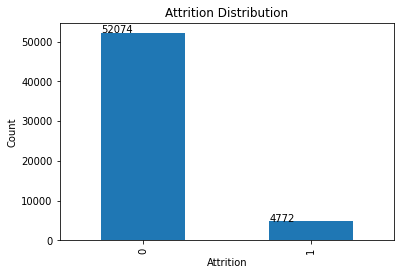

In [23]:
ax = agg_data['Leave/ Stay'].value_counts().plot.bar()
plt.title('Attrition Distribution')
plt.xlabel('Attrition')
plt.ylabel('Count') 
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [17]:
le = LabelEncoder()
agg_data['Tenure_Group']=le.fit_transform(agg_data['Tenure_Group'])
agg_data['SubRegion']=le.fit_transform(agg_data['SubRegion'])
agg_data['Work_Country']=le.fit_transform(agg_data['Work_Country'])
agg_data['Location']=le.fit_transform(agg_data['Location'])
agg_data['COMB_QUEUE_NM']=le.fit_transform(agg_data['COMB_QUEUE_NM'])
agg_data['LOB']=le.fit_transform(agg_data['LOB'])
agg_data['MFR_Role']=le.fit_transform(agg_data['MFR_Role'])
agg_data['Job_Grade']=le.fit_transform(agg_data['Job_Grade'])
agg_data['Function']=le.fit_transform(agg_data['Function'])

In [18]:
agg_data.drop(['Employee_Type', 'Supervisor_Name', 'EPI_TITLE', 'EPI_STATUS', 'EPI_Location', 
               'EPI_TeamName', 'Job_Title'], axis=1, inplace=True)

In [19]:
print(agg_data.shape)
agg_data.head()

(56846, 10)


,Tenure_Group,SubRegion,Work_Country,Location,COMB_QUEUE_NM,LOB,MFR_Role,Job_Grade,Function,Leave/ Stay
1,2,1,1,25,11,15,11,2,0,0
2,2,1,1,25,7,12,11,2,0,0
3,2,1,1,28,61,21,11,1,0,0
5,2,3,4,27,5,9,11,1,0,0
6,0,5,6,2,29,21,11,1,0,0


In [37]:
X = agg_data[['Tenure_Group', 'SubRegion', 'Work_Country', 'Location', 'COMB_QUEUE_NM', 'LOB', 'MFR_Role', 
              'Job_Grade', 'Function']]
y = agg_data['Leave/ Stay'] 

# Splitting by stratifying by cluster name for equal representation of data  # test size=30%, train 70%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [38]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (39792, 9)
Number transactions y_train dataset:  (39792,)
Number transactions X_test dataset:  (17054, 9)
Number transactions y_test dataset:  (17054,)


In [40]:
from collections import Counter
counter_y = Counter(y)
print(counter_y)

Counter({0: 52074, 1: 4772})


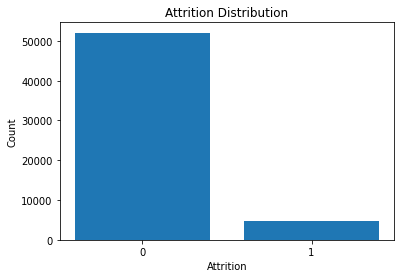

In [44]:
labels_y, values_y = zip(*Counter(y).items())

indexes = np.arange(len(labels_y))

y1=plt.bar(indexes, values_y)
plt.xticks(indexes, labels_y)
plt.title('Attrition Distribution')
plt.xlabel('Attrition')
plt.ylabel('Count') 
plt.show()

In [51]:
from collections import Counter
counter_y_train = Counter(y_train)
print(counter_y_train)

Counter({0: 36414, 1: 3378})


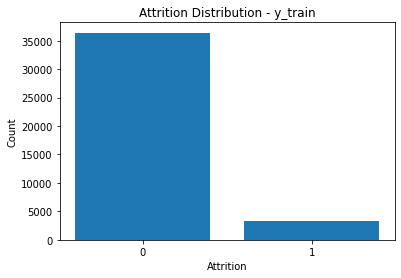

In [52]:
labels_y_train, values_y_train = zip(*Counter(y_train).items())

indexes = np.arange(len(labels_y_train))

y2=plt.bar(indexes, values_y_train)
plt.xticks(indexes, labels_y_train)
plt.title('Attrition Distribution - y_train')
plt.xlabel('Attrition')
plt.ylabel('Count') 
plt.show()

In [53]:
from collections import Counter
counter_y_test = Counter(y_test)
print(counter_y_test)

Counter({0: 15660, 1: 1394})


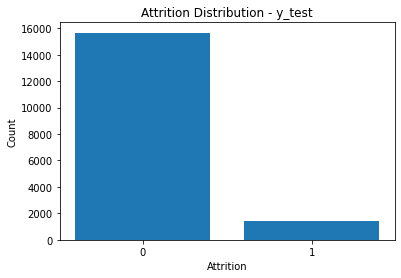

In [54]:
labels_y_test, values_y_test = zip(*Counter(y_test).items())

indexes = np.arange(len(labels_y_test))

y3=plt.bar(indexes, values_y_test)
plt.xticks(indexes, labels_y_test)
plt.title('Attrition Distribution - y_test')
plt.xlabel('Attrition')
plt.ylabel('Count') 
plt.show()

**Oversampling**

In [46]:
oversample = SMOTE(sampling_strategy='minority')
os_X_train, os_y_train = oversample.fit_resample(X_train, y_train)

In [47]:
#confirm the data has been balanced
len(X_test) + len(X_train)

56846

In [55]:
counter_os_y_train = Counter(os_y_train)
print(counter_os_y_train)

Counter({0: 36414, 1: 36414})


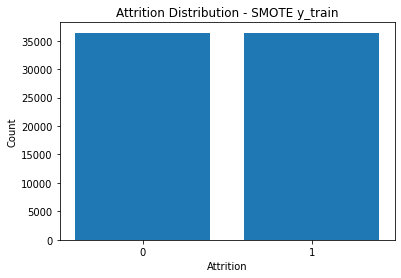

Counter({0: 36414, 1: 36414})


In [68]:
counter_os_y_train = Counter(os_y_train)

labels_os_y_train, values_os_y_train = zip(*Counter(os_y_train).items())

indexes = np.arange(len(labels_os_y_train))

y4=plt.bar(indexes, values_os_y_train)
plt.xticks(indexes, labels_os_y_train)
plt.title('Attrition Distribution - SMOTE y_train')
plt.xlabel('Attrition')
plt.ylabel('Count') 
plt.show()
print(counter_os_y_train)

In [59]:
print("Number transactions os_X_train dataset: ", os_X_train.shape)
print("Number transactions os_y_train dataset: ", os_y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions os_X_train dataset:  (72828, 9)
Number transactions os_y_train dataset:  (72828,)
Number transactions X_test dataset:  (17054, 9)
Number transactions y_test dataset:  (17054,)


In [60]:
gb = GradientBoostingClassifier()
gb.fit(os_X_train, os_y_train)
y_pred = gb.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
75.77%
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     15660
           1       0.22      0.78      0.34      1394

    accuracy                           0.76     17054
   macro avg       0.60      0.77      0.60     17054
weighted avg       0.91      0.76      0.81     17054



In [61]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(os_X_train, os_y_train)
y_pred = xgb.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))

[16:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Accuracy score: 
85.65%
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     15660
           1       0.35      0.86      0.50      1394

    accuracy                           0.86     17054
   macro avg       0.67      0.86      0.71     17054
weighted avg       0.93      0.86      0.88     17054



In [62]:
rf = RandomForestClassifier()
rf.fit(os_X_train, os_y_train)
y_pred = rf.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
83.97%
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     15660
           1       0.32      0.89      0.48      1394

    accuracy                           0.84     17054
   macro avg       0.66      0.86      0.69     17054
weighted avg       0.93      0.84      0.87     17054



In [63]:
gnb = GaussianNB()
gnb.fit(os_X_train, os_y_train)
y_pred = gnb.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
70.15%
              precision    recall  f1-score   support

           0       0.93      0.73      0.82     15660
           1       0.12      0.40      0.18      1394

    accuracy                           0.70     17054
   macro avg       0.52      0.56      0.50     17054
weighted avg       0.87      0.70      0.77     17054



In [64]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(os_X_train, os_y_train)
y_pred = knn.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
92.78%
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     15660
           1       0.57      0.46      0.51      1394

    accuracy                           0.93     17054
   macro avg       0.76      0.72      0.74     17054
weighted avg       0.92      0.93      0.92     17054



In [65]:
mlp = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto',hidden_layer_sizes=(30,30,30),solver='adam')
mlp.fit(os_X_train, os_y_train)
y_pred = mlp.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
81.91%
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     15660
           1       0.30      0.89      0.45      1394

    accuracy                           0.82     17054
   macro avg       0.64      0.85      0.67     17054
weighted avg       0.93      0.82      0.86     17054



In [66]:
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                      })
    return df

#outputs for every model
model1 = model_report(gb, X_train, X_test, y_train, y_test,
                      "Gradient Boosting")
model2 = model_report(xgb, X_train, X_test, y_train, y_test,
                      "XGBoost")
model3 = model_report(rf, X_train, X_test, y_train, y_test,
                      "Random Forest")
model4 = model_report(gnb, X_train, X_test, y_train, y_test,
                      "Gaussian Naïve Bayes")
model5 = model_report(knn, X_train, X_test, y_train, y_test,
                      "KNN Classifier")
model6 = model_report(mlp, X_train, X_test, y_train, y_test,
                      "Neural Network")

#concat all models
model_performances = pd.concat([model1,model2,model3,model4,model5,model6],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

[16:02:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [69]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,x = model_performances[metric],orientation = "h",
                    name = metric ,marker = dict(line = dict(width =.7),color = color))
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "metric",zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)', zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")

data = [trace1,trace2,trace3,trace4]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

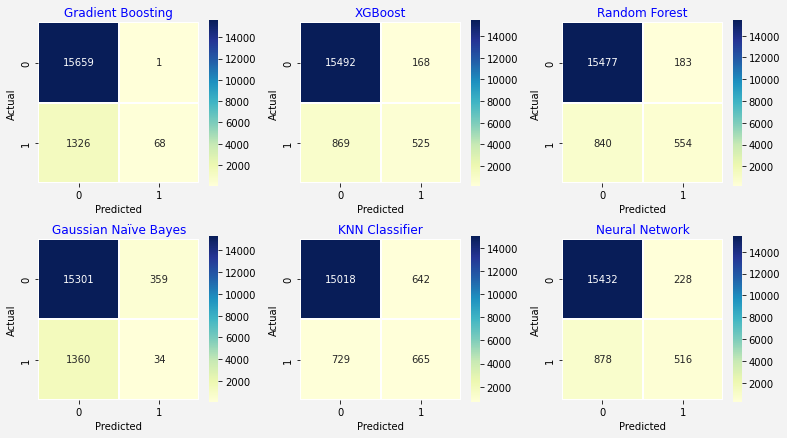

In [67]:
import itertools

lst    = [gb, xgb, rf, gnb, knn, mlp]

length = len(lst)

mods   = ['Gradient Boosting', 'XGBoost', 'Random Forest', 'Gaussian Naïve Bayes', 'KNN Classifier', 'Neural Network']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    predictions = i.predict(X_test)
    conf_matrix = confusion_matrix(y_test,predictions)
    sns.heatmap(conf_matrix,annot=True,fmt = "g",square = True,
#                 xticklabels=[0,1],
#                 yticklabels=[0,1],
                linewidths = 2,linecolor = "w",cmap="YlGnBu")
    plt.title(k,color = "b")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.subplots_adjust(wspace = .3,hspace = .3)

**Undersampling**

In [134]:
undersample = RandomUnderSampler()
us_X_train, us_y_train = undersample.fit_resample(X_train, y_train)

In [135]:
counter = Counter(us_y_train)
print(counter)

Counter({0: 3317, 1: 3317})


In [136]:
print("Number transactions X_train dataset: ", us_X_train.shape)
print("Number transactions y_train dataset: ", us_y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (6634, 9)
Number transactions y_train dataset:  (6634,)
Number transactions X_test dataset:  (17054, 9)
Number transactions y_test dataset:  (17054,)


In [137]:
len(X_test) + len(X_train)

56846

In [138]:
gb = GradientBoostingClassifier()
gb.fit(us_X_train, us_y_train)
y_pred = gb.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
72.97%
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     15599
           1       0.21      0.78      0.33      1455

    accuracy                           0.73     17054
   macro avg       0.59      0.75      0.58     17054
weighted avg       0.91      0.73      0.79     17054



In [139]:
xgb = XGBRegressor()
xgb.fit(us_X_train, us_y_train)
y_pred = xgb.predict(X_test)
# predictions = [round(value) for value in y_pred]

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred.round())*100))
print(classification_report(y_test,y_pred.round()))


Accuracy score: 
82.95%
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       0.99      0.83      0.90     15599
         1.0       0.32      0.87      0.47      1455

    accuracy                           0.83     17054
   macro avg       0.43      0.57      0.46     17054
weighted avg       0.93      0.83      0.86     17054



In [140]:
rf = RandomForestClassifier()
rf.fit(us_X_train, us_y_train)
y_pred = rf.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
83.35%
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     15599
           1       0.32      0.86      0.47      1455

    accuracy                           0.83     17054
   macro avg       0.65      0.85      0.68     17054
weighted avg       0.93      0.83      0.86     17054



In [141]:
gnb = GaussianNB()
gnb.fit(us_X_train, us_y_train)
y_pred = gnb.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
69.12%
              precision    recall  f1-score   support

           0       0.93      0.71      0.81     15599
           1       0.13      0.45      0.20      1455

    accuracy                           0.69     17054
   macro avg       0.53      0.58      0.50     17054
weighted avg       0.86      0.69      0.76     17054



In [142]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(us_X_train, us_y_train)
y_pred = knn.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
92.21%
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     15599
           1       0.57      0.36      0.44      1455

    accuracy                           0.92     17054
   macro avg       0.76      0.67      0.70     17054
weighted avg       0.91      0.92      0.91     17054



In [143]:
mlp = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto',hidden_layer_sizes=(30,30,30),solver='adam')
mlp.fit(us_X_train, us_y_train)
y_pred = mlp.predict(X_test)

print("\nAccuracy score: \n{:.2f}%".format(metrics.accuracy_score(y_test, y_pred)*100))
print(classification_report(y_test,y_pred))


Accuracy score: 
80.66%
              precision    recall  f1-score   support

           0       0.97      0.82      0.89     15599
           1       0.26      0.68      0.38      1455

    accuracy                           0.81     17054
   macro avg       0.61      0.75      0.63     17054
weighted avg       0.90      0.81      0.84     17054



In [144]:
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions.round())
    recallscore  = recall_score(testing_y,predictions.round())
    precision    = precision_score(testing_y,predictions.round())
    roc_auc      = roc_auc_score(testing_y,predictions.round())
    f1score      = f1_score(testing_y,predictions.round()) 
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                      })
    return df

#outputs for every model
model1 = model_report(gb, X_train, X_test, y_train, y_test,
                      "Gradient Boosting")
model2 = model_report(xgb, X_train, X_test, y_train, y_test,
                      "XGBoost")
model3 = model_report(rf, X_train, X_test, y_train, y_test,
                      "Random Forest")
model4 = model_report(gnb, X_train, X_test, y_train, y_test,
                      "Gaussian Naïve Bayes")
model5 = model_report(knn, X_train, X_test, y_train, y_test,
                      "KNN Classifier")
model6 = model_report(mlp, X_train, X_test, y_train, y_test,
                      "Neural Network")

#concat all models
model_performances = pd.concat([model1,model2,model3,model4,model5,model6],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

In [145]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,x = model_performances[metric],orientation = "h",
                    name = metric ,marker = dict(line = dict(width =.7),color = color))
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "metric",zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)', zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
# trace4  = output_tracer('f1_score',"lightgrey")

data = [trace1,trace2,trace3]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

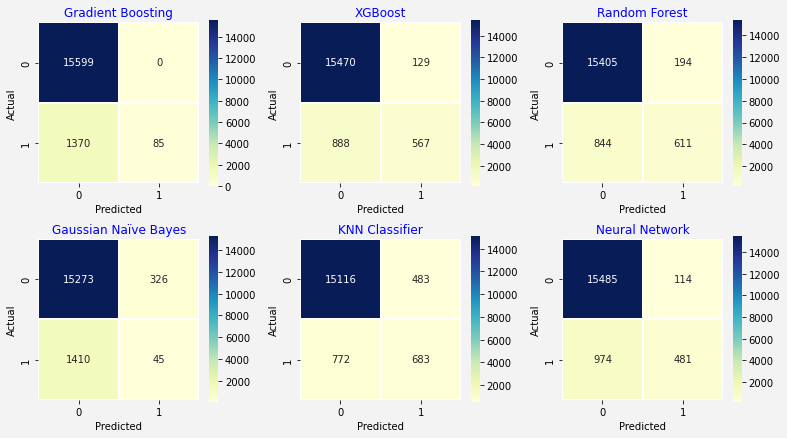

In [146]:
import itertools

lst    = [gb, xgb, rf, gnb, knn, mlp]

length = len(lst)

mods   = ['Gradient Boosting', 'XGBoost', 'Random Forest', 'Gaussian Naïve Bayes', 'KNN Classifier', 'Neural Network']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    predictions = i.predict(X_test)
    conf_matrix = confusion_matrix(y_test,predictions.round())
    sns.heatmap(conf_matrix,annot=True,fmt = "g",square = True,
#                 xticklabels=[0,1],
#                 yticklabels=[0,1],
                linewidths = 2,linecolor = "w",cmap="YlGnBu")
    plt.title(k,color = "b")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.subplots_adjust(wspace = .3,hspace = .3)